# Detection of insults and sarcasm in Kazakh text


Ayazhan Duysekhan, Zeinep Kuanyshova
BD - 2007, BD - 2004


Supervisor: Ermek Alimzhanov

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# importing modules

import re
import nltk
import plotly.graph_objects as go
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from pymystem3 import Mystem
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
nltk.download('stopwords')
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from razdel import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zeinep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zeinep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
com = pd.read_excel('com_balanced-3.xlsx')
com.sample(5)

label                                           comments
6069      0              Ужас қашан дамимыз, мына көріністі-ай
2607      0  мыналар жумыс істеп жетыстермейды , тоқаевқа о...
1576      2                    Ән айтып отырған айел қуад екен
6180      0                                      Мынау не біле
4009      1  Мама мына еркек еркек емес ез екен құрсын жаға...

In [3]:
com.shape

(8394, 2)

In [4]:
import sklearn
print(sklearn.__version__)

1.2.2


In [5]:
label_counts = com['label'].value_counts()
print(label_counts)

0    2918
2    2850
1    2626
Name: label, dtype: int64


# Data Cleaning and Preprocessing

In [6]:
from __future__ import print_function
import os

from kaznlp.normalization.ininorm import Normalizer

from kaznlp.tokenization.tokrex import TokenizeRex
from kaznlp.tokenization.tokhmm import TokenizerHMM

from kaznlp.lid.lidnb import LidNB

from kaznlp.morphology.analyzers import AnalyzerDD
from kaznlp.morphology.taggers import TaggerHMM


### Removing Punctuations and emojies

In [7]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
def remove_punc(text):
    remove = "".join([char for char in text if char not in string.punctuation])
    return remove

com["com"] = com["comments"].apply(lambda x: remove_punc(x).lower())

com.sample(5)

label                                           comments  \
244       0                            Шақыру түссе,бару керек   
28        0  Билiк халықты надан, акымак санағанмен, бiрак ...   
331       1  МАҚАУДЫ АЯП КЕТТІМҒОЙ ҚАНША ЕҢБЕК АНАУ АЛАЯҚТЫ...   
5725      0         Ауылбереке, Ауылбереке! Прямой Ауылбереке.   
3193      2  Мыналар қайдам елді көркейтет дегенге кім сене...   

                                                    com  
244                              шақыру түссебару керек  
28    билiк халықты надан акымак санағанмен бiрак ха...  
331   мақауды аяп кеттімғой қанша еңбек анау алаяқты...  
5725            ауылбереке ауылбереке прямой ауылбереке  
3193  мыналар қайдам елді көркейтет дегенге кім сене...

In [9]:
import emoji

def remove_emojis(text):
    return emoji.get_emoji_regexp().sub('', text)
for column in com.columns:
    com["cleaned_com"] = com["com"].apply(remove_emojis)
    
com.sample(5)

<ipython-input-9-c240bbaf2ff7>:4: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return emoji.get_emoji_regexp().sub('', text)


label                                           comments  \
6774      0                                   Не деген сұмдық?   
4763      0  Жанұяңызға бақ, береке, табыс, ырыс, несібе тө...   
6285      2  жаңылмайтын жақ, сүрінбейтін тұяқ жоқ бәрі жақ...   
2650      2              Менікі сенікі не понимает деп тұр ғой   
5907      0  Атада настроение жоқ қой! Бәйбіше әдемі екен. ...   

                                                    com  \
6774                                    не деген сұмдық   
4763   жанұяңызға бақ береке табыс ырыс несібе төгілсін   
6285  жаңылмайтын жақ сүрінбейтін тұяқ жоқ бәрі жақс...   
2650              менікі сенікі не понимает деп тұр ғой   
5907  атада настроение жоқ қой бәйбіше әдемі екен ба...   

                                            cleaned_com  
6774                                    не деген сұмдық  
4763   жанұяңызға бақ береке табыс ырыс несібе төгілсін  
6285  жаңылмайтын жақ сүрінбейтін тұяқ жоқ бәрі жақс...  
2650              менікі сенікі не понимает деп тұр ғой  
5907  атада настроение жоқ қой бәйбіше әдемі екен ба...

### Normalization

In [10]:
ininormer = Normalizer()
com["normalized_com"]=com.apply(lambda row: ininormer.normalize(row["cleaned_com"], desegment=2, dedupe=2, stats=False).lower(), axis=1)  
print(com["normalized_com"][:5], sep = "\n")

0    жақсы бір өзіне сай азамат таппадынба шайтан ғ...
1    ринат биликтеглердин созин соилеп калыпсынгои ...
2    ыгаими мен сыгаи мусылман аты садака кетсин ак...
3                                 позор еркекте ес жоқ
4    атырауға қыдырып емес жұмыс жасауға келгендер ...
Name: normalized_com, dtype: object


In [11]:
com.sample(5)

label                                           comments  \
4855      2              Мына психологтың өзіне психолог керек   
4489      1  Мынандай басыістемеитін психолықты неменеге ша...   
4676      2    Көремізге,немесе Астарлы ақиқатқа бармадыңызба.   
5096      1  Қолы сынғыр қатын оз баласын солай қорлау кере...   
1075      1                                     Байғұс әйелдер   

                                                    com  \
4855              мына психологтың өзіне психолог керек   
4489  мынандай басыістемеитін психолықты неменеге ша...   
4676      көремізгенемесе астарлы ақиқатқа бармадыңызба   
5096  қолы сынғыр қатын оз баласын солай қорлау кере...   
1075                                     байғұс әйелдер   

                                            cleaned_com  \
4855              мына психологтың өзіне психолог керек   
4489  мынандай басыістемеитін психолықты неменеге ша...   
4676      көремізгенемесе астарлы ақиқатқа бармадыңызба   
5096  қолы сынғыр қатын оз баласын солай қорлау кере...   
1075                                     байғұс әйелдер   

                                         normalized_com  
4855              мына психологтың өзіне психолог керек  
4489  мынандай басыістемеитін психолықты неменеге ша...  
4676      көремізгенемесе астарлы ақиқатқа бармадыңызба  
5096  қолы сынғыр қатын оз баласын солай қорлау кере...  
1075                                     байғұс әйелдер

In [12]:
stopwords = nltk.corpus.stopwords.words("kazakh") 

def remove_stopwords(token):
    text = [word for word in token if word not in stopwords]# to remove all stopwords
    return text

com["non_stop"] = com["normalized_com"].apply(lambda x: remove_stopwords(x))
com.head()

label                                           comments  \
0      1  жақсы бір өзіне сай азамат таппадынба? Шайтан ...   
1      2  Ринат биликтеглердин созин соилеп калыпсынгои ...   
2      2  Ыгаими мен сыгаи мусылман аты садака кетсин ак...   
3      1                               Позор еркекте ес жоқ   
4      0  Атырауға қыдырып емес жұмыс жасауға келгендер ...   

                                                 com  \
0  жақсы бір өзіне сай азамат таппадынба шайтан ғ...   
1  ринат биликтеглердин созин соилеп калыпсынгои ...   
2  ыгаими мен сыгаи мусылман аты садака кетсин ак...   
3                               позор еркекте ес жоқ   
4  атырауға қыдырып емес жұмыс жасауға келгендер ...   

                                         cleaned_com  \
0  жақсы бір өзіне сай азамат таппадынба шайтан ғ...   
1  ринат биликтеглердин созин соилеп калыпсынгои ...   
2  ыгаими мен сыгаи мусылман аты садака кетсин ак...   
3                               позор еркекте ес жоқ   
4  атырауға қыдырып емес жұмыс жасауға келгендер ...   

                                      normalized_com  \
0  жақсы бір өзіне сай азамат таппадынба шайтан ғ...   
1  ринат биликтеглердин созин соилеп калыпсынгои ...   
2  ыгаими мен сыгаи мусылман аты садака кетсин ак...   
3                               позор еркекте ес жоқ   
4  атырауға қыдырып емес жұмыс жасауға келгендер ...   

                                            non_stop  
0  [ж, а, қ, с, ы,  , б, і, р,  , ө, з, і, н,  , ...  
1  [р, и, н, а, т,  , б, и, л, и, к, т, г, л, р, ...  
2  [ы, г, а, и, м, и,  , м, н,  , с, ы, г, а, и, ...  
3            [п, з, р,  , р, к, к, т,  , с,  , ж, қ]  
4  [а, т, ы, р, а, у, ғ, а,  , қ, ы, д, ы, р, ы, ...

In [13]:
com

label                                           comments  \
0         1  жақсы бір өзіне сай азамат таппадынба? Шайтан ...   
1         2  Ринат биликтеглердин созин соилеп калыпсынгои ...   
2         2  Ыгаими мен сыгаи мусылман аты садака кетсин ак...   
3         1                               Позор еркекте ес жоқ   
4         0  Атырауға қыдырып емес жұмыс жасауға келгендер ...   
...     ...                                                ...   
8389      2          Озы кишкантай баладай минезы. Сойлегениде   
8390      0              Бірдене жазайын сендер лайк басыңдар😅   
8391      0                                    Бастамасы жақсы   
8392      0            Көріп бастадым) біткенде жазам отзывты)   
8393      2  Няғыл дит, қарауға болама, уақытымызды арнауға...   

                                                    com  \
0     жақсы бір өзіне сай азамат таппадынба шайтан ғ...   
1     ринат биликтеглердин созин соилеп калыпсынгои ...   
2     ыгаими мен сыгаи мусылман аты садака кетсин ак...   
3                                  позор еркекте ес жоқ   
4     атырауға қыдырып емес жұмыс жасауға келгендер ...   
...                                                 ...   
8389           озы кишкантай баладай минезы сойлегениде   
8390              бірдене жазайын сендер лайк басыңдар😅   
8391                                    бастамасы жақсы   
8392              көріп бастадым біткенде жазам отзывты   
8393  няғыл дит қарауға болама уақытымызды арнауға б...   

                                            cleaned_com  \
0     жақсы бір өзіне сай азамат таппадынба шайтан ғ...   
1     ринат биликтеглердин созин соилеп калыпсынгои ...   
2     ыгаими мен сыгаи мусылман аты садака кетсин ак...   
3                                  позор еркекте ес жоқ   
4     атырауға қыдырып емес жұмыс жасауға келгендер ...   
...                                                 ...   
8389           озы кишкантай баладай минезы сойлегениде   
8390               бірдене жазайын сендер лайк басыңдар   
8391                                    бастамасы жақсы   
8392              көріп бастадым біткенде жазам отзывты   
8393  няғыл дит қарауға болама уақытымызды арнауға б...   

                                         normalized_com  \
0     жақсы бір өзіне сай азамат таппадынба шайтан ғ...   
1     ринат биликтеглердин созин соилеп калыпсынгои ...   
2     ыгаими мен сыгаи мусылман аты садака кетсин ак...   
3                                  позор еркекте ес жоқ   
4     атырауға қыдырып емес жұмыс жасауға келгендер ...   
...                                                 ...   
8389           озы кишкантай баладай минезы сойлегениде   
8390               бірдене жазайын сендер лайк басыңдар   
8391                                    бастамасы жақсы   
8392              көріп бастадым біткенде жазам отзывты   
8393  няғыл дит қарауға болама уақытымызды арнауға б...   

                                               non_stop  
0     [ж, а, қ, с, ы,  , б, і, р,  , ө, з, і, н,  , ...  
1     [р, и, н, а, т,  , б, и, л, и, к, т, г, л, р, ...  
2     [ы, г, а, и, м, и,  , м, н,  , с, ы, г, а, и, ...  
3               [п, з, р,  , р, к, к, т,  , с,  , ж, қ]  
4     [а, т, ы, р, а, у, ғ, а,  , қ, ы, д, ы, р, ы, ...  
...                                                 ...  
8389  [з, ы,  , к, и, ш, к, а, н, т, а, й,  , б, а, ...  
8390  [б, і, р, д, н,  , ж, а, з, а, й, ы, н,  , с, ...  
8391      [б, а, с, т, а, м, а, с, ы,  , ж, а, қ, с, ы]  
8392  [к, ө, р, і, п,  , б, а, с, т, а, д, ы, м,  , ...  
8393  [н, ғ, ы, л,  , д, и, т,  , қ, а, р, а, у, ғ, ...  

[8394 rows x 6 columns]

### Tokenization, removing stop words, lemmatization, stemming

In [14]:
com['tokenized_com'] = com['normalized_com'].apply(lambda x: [token.text for token in tokenize(x)])

# Remove stop words using the NLTK package
stop_words = nltk.corpus.stopwords.words("kazakh") 
com['non_stop'] = com['tokenized_com'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

# Alternatively, perform stemming using the SnowballStemmer from the NLTK package
stemmer = SnowballStemmer('russian')
com['stemmed'] = com['non_stop'].apply(lambda x: [stemmer.stem(word) for word in x])

# Lemmatization using the WordNetLemmatizer from the NLTK package
lemmatizer = WordNetLemmatizer()
com['lemmatized'] = com['non_stop'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
com.sample(5)

label                                           comments  \
6315      1  Мына әже шалбар киіпті,шашы мужской прический,...   
7985      1                                      Малго мынау 😂   
6836      0                                  Бәрекелді ризамын   
2747      2                         Да патамушта деп коймадыго   
5266      2                                Мыналар,да,ми,барма   

                                                    com  \
6315  мына әже шалбар киіптішашы мужской прический қ...   
7985                                      малго мынау 😂   
6836                                  бәрекелді ризамын   
2747                         да патамушта деп коймадыго   
5266                                   мыналардамибарма   

                                            cleaned_com  \
6315  мына әже шалбар киіптішашы мужской прический қ...   
7985                                       малго мынау    
6836                                  бәрекелді ризамын   
2747                         да патамушта деп коймадыго   
5266                                   мыналардамибарма   

                                         normalized_com  \
6315  мына әже шалбар киіптішашы мужской прический қ...   
7985                                       малго мынау    
6836                                  бәрекелді ризамын   
2747                         да патамушта деп коймадыго   
5266                                   мыналардамибарма   

                                               non_stop  \
6315  [әже, шалбар, киіптішашы, мужской, прический, ...   
7985                                            [малго]   
6836                                          [ризамын]   
2747                    [да, патамушта, деп, коймадыго]   
5266                                 [мыналардамибарма]   

                                          tokenized_com  \
6315  [мына, әже, шалбар, киіптішашы, мужской, приче...   
7985                                     [малго, мынау]   
6836                               [бәрекелді, ризамын]   
2747                    [да, патамушта, деп, коймадыго]   
5266                                 [мыналардамибарма]   

                                                stemmed  \
6315  [әже, шалбар, киіптішаш, мужск, прическ, қайра...   
7985                                             [малг]   
6836                                          [ризамын]   
2747                      [да, патамушт, деп, коймадыг]   
5266                                  [мыналардамибарм]   

                                             lemmatized  
6315  [әже, шалбар, киіптішашы, мужской, прический, ...  
7985                                            [малго]  
6836                                          [ризамын]  
2747                    [да, патамушта, деп, коймадыго]  
5266                                 [мыналардамибарма]

In [15]:
com["tokenized_com"].sample(10)

3545    [шли, акылдысын, гой, акылын, коп, болып, кеткен]
5414                      [өте, дұрыс, шешім, қабылдапты]
2081                 [жандостан, басқа, адам, жоқ, бекен]
4809                                  [багалары, 5, тиын]
4807        [қой, бұл, тірлігіңді, шыдамныңда, шегі, бар]
597     [халық, жауы, деген, атаққа, ие, болғанша, ест...
979                                      [ёхерный, бабай]
1679                                      [бойын, қортық]
1209    [беттери, табактай, боп, экранга, симай, тур, ...
7646    [неге, сонша, ангиме, коп, анеля, жаксы, кыз, ...
Name: tokenized_com, dtype: object

# Data Analysis

In [16]:
import string

# Function to calculate length of message excluding space
com['com_char'] = com['normalized_com'].apply(lambda x: len(x) - x.count(" "))
com['com_words'] = com['normalized_com'].apply(lambda x:  x.count(" ")+1)

In [17]:
com.sample(5)

label                                           comments  \
2669      2                 Ояныңдар халқым спектакль бітпейді   
6643      2                           Байбек сияктылар коп го,   
654       1           Ужаас қандаи оңбаған еркек қатынқұмар 😱😱   
3956      1                                       Орыс екенгой   
4145      2  Бұлай күлкілі болғанша шықпайақ қоймайма бұлар...   

                                                    com  \
2669                 ояныңдар халқым спектакль бітпейді   
6643                            байбек сияктылар коп го   
654            ужаас қандаи оңбаған еркек қатынқұмар 😱😱   
3956                                       орыс екенгой   
4145  бұлай күлкілі болғанша шықпайақ қоймайма бұлар...   

                                            cleaned_com  \
2669                 ояныңдар халқым спектакль бітпейді   
6643                            байбек сияктылар коп го   
654              ужаас қандаи оңбаған еркек қатынқұмар    
3956                                       орыс екенгой   
4145  бұлай күлкілі болғанша шықпайақ қоймайма бұлар...   

                                         normalized_com  \
2669                 ояныңдар халқым спектакль бітпейді   
6643                            байбек сияктылар коп го   
654              ужаас қандаи оңбаған еркек қатынқұмар    
3956                                       орыс екенгой   
4145  бұлай күлкілі болғанша шықпайақ қоймайма бұлар...   

                                               non_stop  \
2669            [ояныңдар, халқым, спектакль, бітпейді]   
6643                       [байбек, сияктылар, коп, го]   
654         [ужаас, қандаи, оңбаған, еркек, қатынқұмар]   
3956                                    [орыс, екенгой]   
4145  [бұлай, күлкілі, болғанша, шықпайақ, қоймайма,...   

                                          tokenized_com  \
2669            [ояныңдар, халқым, спектакль, бітпейді]   
6643                       [байбек, сияктылар, коп, го]   
654         [ужаас, қандаи, оңбаған, еркек, қатынқұмар]   
3956                                    [орыс, екенгой]   
4145  [бұлай, күлкілі, болғанша, шықпайақ, қоймайма,...   

                                                stemmed  \
2669               [ояныңдар, халқ, спектакл, бітпейді]   
6643                       [байбек, сияктылар, коп, го]   
654           [ужаас, қанда, оңбаға, еркек, қатынқұмар]   
3956                                      [орыс, екенг]   
4145  [бұла, күлкілі, болғанш, шықпайақ, қоймайм, бұ...   

                                             lemmatized  com_char  com_words  
2669            [ояныңдар, халқым, спектакль, бітпейді]        31          4  
6643                       [байбек, сияктылар, коп, го]        20          4  
654         [ужаас, қандаи, оңбаған, еркек, қатынқұмар]        33          6  
3956                                    [орыс, екенгой]        11          2  
4145  [бұлай, күлкілі, болғанша, шықпайақ, қоймайма,...       120         20

In [18]:
import seaborn as sns
#Setting the size and grid for plotting
sns.set(rc= {"figure.figsize": (8, 6)})

bins = np.linspace(0, 200, 40)
plt.hist(com[com['label']==0]['com_char'], bins, alpha=0.5, density=True, label='neutral')
plt.hist(com[com['label']==1]['com_char'], bins, alpha=0.5, density=True, label='insult')
plt.hist(com[com['label']==2]['com_char'], bins, alpha=0.5, density=True, label='sarcasm')

plt.legend(loc='upper left')
plt.show()

In [19]:
import seaborn as sns
#Setting the size and grid for plotting
sns.set(rc= {"figure.figsize": (8, 6)})

bins = np.linspace(0, 50, 40)
plt.hist(com[com['label']==0]['com_words'], bins, alpha=0.5, density=True, label='neutral')
plt.hist(com[com['label']==1]['com_words'], bins, alpha=0.5, density=True, label='insult')
plt.hist(com[com['label']==2]['com_words'], bins, alpha=0.5, density=True, label='sarcasm')


plt.legend(loc='upper left')
plt.show()

In [20]:
x=com['label'].value_counts().values
sns.barplot(["neutral","sarcasm", "insult"],x)
plt.title('Target variable count')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Target variable count')

## Tfidf Vectorizer

In [21]:
from sklearn.model_selection import train_test_split

X=com[['lemmatized','com_char', 'com_words']]
y=com['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

def to_tfidf(text):
    return ' '.join(text)

X = tfidf.fit_transform(com['lemmatized'].apply(to_tfidf))
y = com['label']

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

lemmatized_train = [' '.join(tokens) for tokens in X_train['lemmatized']]
lemmatized_test = [' '.join(tokens) for tokens in X_test['lemmatized']]

# Create and apply TfidfVectorizer on training data
tfidf_vect = TfidfVectorizer()
tfidf_train = tfidf_vect.fit_transform(lemmatized_train)
tfidf_test = tfidf_vect.transform(lemmatized_test)

# Create a Data Frame with attributes and combine it with other columns
X_train_vect = pd.concat([X_train[['com_char', 'com_words']].reset_index(drop=True),
                          pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['com_char', 'com_words']].reset_index(drop=True),
                         pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

com_char  com_words    0         1    2    3    4    5    6    7  ...  \
0        90         11  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1        86         15  0.0  0.255516  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2        45          5  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3       116         20  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4        10          3  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   

   15820  15821  15822  15823  15824  15825  15826  15827  15828  15829  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 15832 columns]

## CountVectorizer

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
messages_bow=CountVectorizer().fit_transform(com['normalized_com'])


In [25]:
com[['normalized_com','com_char','com_words']]

normalized_com  com_char  com_words
0     жақсы бір өзіне сай азамат таппадынба шайтан ғ...        46          9
1     ринат биликтеглердин созин соилеп калыпсынгои ...        76         10
2     ыгаими мен сыгаи мусылман аты садака кетсин ак...        57         12
3                                  позор еркекте ес жоқ        17          4
4     атырауға қыдырып емес жұмыс жасауға келгендер ...        45          7
...                                                 ...       ...        ...
8389           озы кишкантай баладай минезы сойлегениде        36          5
8390               бірдене жазайын сендер лайк басыңдар        32          5
8391                                    бастамасы жақсы        14          2
8392              көріп бастадым біткенде жазам отзывты        33          5
8393  няғыл дит қарауға болама уақытымызды арнауға б...        45          7

[8394 rows x 3 columns]

In [26]:
messages_bow

<8394x18121 sparse matrix of type '<class 'numpy.int64'>'
	with 69877 stored elements in Compressed Sparse Row format>

In [27]:
messages_bow.shape


(8394, 18121)

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(messages_bow,com['label'],test_size=0.2,random_state=42)

In [29]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import confusion_matrix, classification_report

## Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

X_train_vect.columns = X_train_vect.columns.astype(str)
X_test_vect.columns = X_test_vect.columns.astype(str)

# Creating and training a Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train_vect, y_train)

# Prediction based on test data
y_pred = logreg.predict(X_test_vect)

# A
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
fscore = f1_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)

print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}%'.format(
    round(precision, 3), round(recall, 3), round(fscore, 3), round(accuracy * 100, 3)))

# Generate and plot the confusion matrix
sns.set(rc={"figure.figsize": (8, 6)})
cm = confusion_matrix(y_test, y_pred)
class_label = ["1", "0", "2"]
df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap='Greens') 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision: 0.679 / Recall: 0.679 / F1-Score: 0.679 / Accuracy: 67.898%


In [31]:
classifier = LogisticRegression().fit(x_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
print(classifier.predict(x_train))
print(y_train.values)

[0 2 2 ... 0 1 1]
[0 2 2 ... 0 1 1]


In [33]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
pred=classifier.predict(x_train)
print(classification_report(y_train,pred))
print('confusion matrix:\n', confusion_matrix(y_train,pred))
print('accuracy:',accuracy_score(y_train,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2311
           1       0.99      0.99      0.99      2106
           2       0.99      0.99      0.99      2298

    accuracy                           0.99      6715
   macro avg       0.99      0.99      0.99      6715
weighted avg       0.99      0.99      0.99      6715

confusion matrix:
 [[2288   14    9]
 [  15 2081   10]
 [  16   13 2269]]
accuracy: 0.9885331347728965


In [34]:
cm = confusion_matrix(y_train,pred)
cm

array([[2288,   14,    9],
       [  15, 2081,   10],
       [  16,   13, 2269]])

In [35]:
print(classifier.predict(x_test))
print(y_test.values)

[0 1 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


In [36]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
pred=classifier.predict(x_test)
print(classification_report(y_test,pred))
print('confusion matrix:\n', confusion_matrix(y_test,pred))
print('accuracy:',accuracy_score(y_test,pred))
LR=accuracy_score(y_test,pred)

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       607
           1       0.82      0.80      0.81       520
           2       0.80      0.82      0.81       552

    accuracy                           0.80      1679
   macro avg       0.80      0.80      0.80      1679
weighted avg       0.80      0.80      0.80      1679

confusion matrix:
 [[478  56  73]
 [ 63 418  39]
 [ 67  34 451]]
accuracy: 0.802263251935676


In [37]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=10,shuffle=True)
print("Accuracy using Cross Validation is :",np.mean(cross_val_score(classifier,messages_bow,com['label'],cv=kfold,scoring="accuracy"))*100," %")
kfoldLR=np.mean(cross_val_score(classifier,messages_bow,com['label'],cv=kfold,scoring="accuracy"))*100

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy using Cross Validation is : 80.87981724274931  %


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

## MultinomialNB

Precision: 0.701 / Recall: 0.701 / F1-Score: 0.701 / Accuracy: 70.101%


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


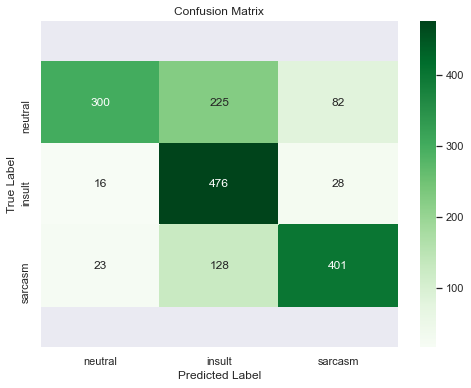

In [38]:
rf = MultinomialNB()

rf_model = rf.fit(X_train_vect, y_train)

y_pred = rf_model.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=0, average='micro')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}%'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(acs(y_test,y_pred)*100, 3)))

sns.set(rc= {"figure.figsize": (8, 6)})

cm = confusion_matrix(y_test, y_pred)
class_label = ["neutral","insult","sarcasm"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap = 'Greens')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [39]:
from sklearn.naive_bayes import MultinomialNB
classifier =MultinomialNB(alpha=1, fit_prior=True).fit(x_train,y_train)

In [40]:
print(classifier.predict(x_train))
print(y_train.values)

[0 2 2 ... 0 1 1]
[0 2 2 ... 0 1 1]


In [41]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
pred=classifier.predict(x_train)
print(classification_report(y_train,pred))
print('confusion matrix:\n', confusion_matrix(y_train,pred))
print('accuracy:',accuracy_score(y_train,pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2311
           1       0.94      0.94      0.94      2106
           2       0.92      0.96      0.94      2298

    accuracy                           0.94      6715
   macro avg       0.94      0.94      0.94      6715
weighted avg       0.94      0.94      0.94      6715

confusion matrix:
 [[2127   76  108]
 [  39 1975   92]
 [  42   47 2209]]
accuracy: 0.9398361876396129


In [42]:
cm = confusion_matrix(y_train,pred)
cm

array([[2127,   76,  108],
       [  39, 1975,   92],
       [  42,   47, 2209]])

In [43]:
print(classifier.predict(x_test))
print(y_test.values)

[0 2 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


In [44]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
pred=classifier.predict(x_test)
print(classification_report(y_test,pred))
print('confusion matrix:\n', confusion_matrix(y_test,pred))
print('accuracy:',accuracy_score(y_test,pred))
NB=accuracy_score(y_test,pred)

              precision    recall  f1-score   support

           0       0.81      0.71      0.76       607
           1       0.77      0.77      0.77       520
           2       0.73      0.82      0.77       552

    accuracy                           0.77      1679
   macro avg       0.77      0.77      0.77      1679
weighted avg       0.77      0.77      0.76      1679

confusion matrix:
 [[430  75 102]
 [ 50 400  70]
 [ 52  45 455]]
accuracy: 0.7653365098272782


In [45]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=10,shuffle=True)
print("Accuracy using Cross Validation is :",np.mean(cross_val_score(classifier,messages_bow,com['label'],cv=kfold,scoring="accuracy"))*100," %")
kfoldNB=np.mean(cross_val_score(classifier,messages_bow,com['label'],cv=kfold,scoring="accuracy"))*100

Accuracy using Cross Validation is : 77.30566433963334  %


## RandomForestClassifier

Precision: 0.799 / Recall: 0.799 / F1-Score: 0.799 / Accuracy: 79.869%


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


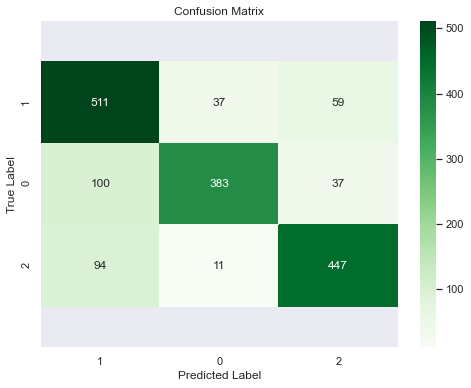

In [46]:
X_train_vect.columns = X_train_vect.columns.astype(str)
X_test_vect.columns = X_test_vect.columns.astype(str)

# Create and train the random forest classifier
rf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1)
rf_model = rf.fit(X_train_vect, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_vect)

# Estimation of model accuracy by calculating metrics
precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=0, average='micro')
accuracy = accuracy_score(y_test, y_pred)

print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}%'.format(
    round(precision, 3), round(recall, 3), round(fscore, 3), round(accuracy * 100, 3)))

# Generate and plot the confusion matrix
sns.set(rc={"figure.figsize": (8, 6)})
cm = confusion_matrix(y_test, y_pred)
class_label = ["1", "0", "2"]
df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap='Greens') 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [47]:
from sklearn.ensemble import RandomForestClassifier
classifier =RandomForestClassifier().fit(x_train,y_train)

In [48]:
print(classifier.predict(x_train))
print(y_train.values)

[0 2 2 ... 0 1 1]
[0 2 2 ... 0 1 1]


In [49]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
pred=classifier.predict(x_train)
print(classification_report(y_train,pred))
print('confusion matrix:\n', confusion_matrix(y_train,pred))
print('accuracy:',accuracy_score(y_train,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2311
           1       1.00      1.00      1.00      2106
           2       1.00      1.00      1.00      2298

    accuracy                           1.00      6715
   macro avg       1.00      1.00      1.00      6715
weighted avg       1.00      1.00      1.00      6715

confusion matrix:
 [[2306    2    3]
 [   1 2102    3]
 [   1    2 2295]]
accuracy: 0.9982129560685034


In [50]:
print(classifier.predict(x_test))
print(y_test.values)

[0 1 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


In [51]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
pred=classifier.predict(x_test)
print(classification_report(y_test,pred))
print('confusion matrix:\n', confusion_matrix(y_test,pred))
print('accuracy:',accuracy_score(y_test,pred))
RF=accuracy_score(y_test,pred)

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       607
           1       0.77      0.78      0.78       520
           2       0.84      0.79      0.82       552

    accuracy                           0.78      1679
   macro avg       0.78      0.78      0.78      1679
weighted avg       0.78      0.78      0.78      1679

confusion matrix:
 [[467  87  53]
 [ 82 407  31]
 [ 78  36 438]]
accuracy: 0.7814175104228708


In [54]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=10,shuffle=True)
print("Accuracy using Cross Validation is :",np.mean(cross_val_score(classifier,messages_bow,com['label'],cv=kfold,scoring="accuracy"))*100," %")
kfoldRF=np.mean(cross_val_score(classifier,messages_bow,com['label'],cv=kfold,scoring="accuracy"))*100

Accuracy using Cross Validation is : 79.13987740507406  %


## GradientBoostingClassifier

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create and train the gradient boosting classifier
gbt = GradientBoostingClassifier(n_estimators=100, max_depth=3)
gbt_model = gbt.fit(X_train_vect, y_train)

# Make predictions on the test set
y_pred = gbt_model.predict(X_test_vect)

# Estimation of model accuracy by calculating metrics
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
fscore = f1_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)

print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}%'.format(
    round(precision, 3), round(recall, 3), round(fscore, 3), round(accuracy * 100, 3)))

# Generate and plot the confusion matrix
sns.set(rc={"figure.figsize": (8, 6)})
cm = confusion_matrix(y_test, y_pred)
class_label = ["1", "0", "2"]
df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap='Greens') 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Precision: 0.591 / Recall: 0.591 / F1-Score: 0.591 / Accuracy: 59.083%


In [58]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
pred=classifier.predict(x_train)
print(classification_report(y_train,pred))
print('confusion matrix:\n', confusion_matrix(y_train,pred))
print('accuracy:',accuracy_score(y_train,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2311
           1       1.00      1.00      1.00      2106
           2       1.00      1.00      1.00      2298

    accuracy                           1.00      6715
   macro avg       1.00      1.00      1.00      6715
weighted avg       1.00      1.00      1.00      6715

confusion matrix:
 [[2306    2    3]
 [   1 2102    3]
 [   1    2 2295]]
accuracy: 0.9982129560685034


In [59]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
pred=classifier.predict(x_test)
print(classification_report(y_test,pred))
print('confusion matrix:\n', confusion_matrix(y_test,pred))
print('accuracy:',accuracy_score(y_test,pred))
GBT=accuracy_score(y_test,pred)

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       607
           1       0.77      0.78      0.78       520
           2       0.84      0.79      0.82       552

    accuracy                           0.78      1679
   macro avg       0.78      0.78      0.78      1679
weighted avg       0.78      0.78      0.78      1679

confusion matrix:
 [[467  87  53]
 [ 82 407  31]
 [ 78  36 438]]
accuracy: 0.7814175104228708


In [53]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=10,shuffle=True)
print("Accuracy using Cross Validation is :",np.mean(cross_val_score(classifier,messages_bow,com['label'],cv=kfold,scoring="accuracy"))*100," %")
kfoldGBT=np.mean(cross_val_score(classifier,messages_bow,com['label'],cv=kfold,scoring="accuracy"))*100

Accuracy using Cross Validation is : 78.31769680458595  %


In [60]:
Result = {'Model': ['Logistic Regression','Naive Bayes', 'Random Forest', 'Gradient Boosting'], 'Accuracy': [LR, NB, RF , GBT],'Cross Validation':[kfoldLR,kfoldNB,kfoldRF,kfoldGBT]} 

In [61]:
df = pd.DataFrame(Result) 

In [62]:
df

Model  Accuracy  Cross Validation
0  Logistic Regression  0.802263         80.772078
1          Naive Bayes  0.765337         77.257421
2        Random Forest  0.781418         78.068009
3    Gradient Boosting  0.781418         78.639154